In [1]:
#import requests
#from bs4 import BeautifulSoup

import pandas as pd
import numpy as np
import time

import seaborn
from matplotlib import pyplot

from sklearn.linear_model import LogisticRegression

%load_ext sql

%config SqlMagic.autopandas = True
%config SqlMagic.feedback = False
%config SqlMagic.displaycon = False

%sql duckdb:///:memory:

In [2]:
#Import raw data
chess_games = pd.read_csv('chess_games.csv')

In [3]:
#Data Cleaning - convert date and time columns to datatime objects
chess_games['UTCDate'] = pd.to_datetime(chess_games['UTCDate'])
chess_games['UTCTime'] = pd.to_datetime(chess_games['UTCTime'])

display(chess_games.head())

#Check to ensure each column type is correct
print(chess_games.dtypes)

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN
0,Classical,eisaaaa,HAMID449,1-0,2016-06-30,2022-10-23 22:00:01,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...
1,Blitz,go4jas,Sergei1973,0-1,2016-06-30,2022-10-23 22:00:01,1641,1627,-11.0,12.0,C20,King's Pawn Opening: 2.b3,300+0,Normal,1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 ...
2,Blitz tournament,Evangelistaizac,kafune,1-0,2016-06-30,2022-10-23 22:00:02,1647,1688,13.0,-13.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Bg4 4. Be2 Nf6 5....
3,Correspondence,Jvayne,Wsjvayne,1-0,2016-06-30,2022-10-23 22:00:02,1706,1317,27.0,-25.0,A00,Van't Kruijs Opening,-,Normal,1. e3 Nf6 2. Bc4 d6 3. e4 e6 4. Nf3 Nxe4 5. Nd...
4,Blitz tournament,kyoday,BrettDale,0-1,2016-06-30,2022-10-23 22:00:02,1945,1900,-14.0,13.0,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit,1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...


Event                      object
White                      object
Black                      object
Result                     object
UTCDate            datetime64[ns]
UTCTime            datetime64[ns]
WhiteElo                    int64
BlackElo                    int64
WhiteRatingDiff           float64
BlackRatingDiff           float64
ECO                        object
Opening                    object
TimeControl                object
Termination                object
AN                         object
dtype: object


In [4]:
#filter out Termination = Abandoned, Rules infraction, filtering out TimeControl = '-'
#checking that there are no games where result is * (meaning incomplete)
completed_chess_games = %sql SELECT * FROM chess_games \
WHERE Termination NOT IN ('Abandoned', 'Rules infraction') \
    AND TimeControl != '-' \
    AND Result != '*'


In [5]:
#filter out all NaN values
completed_chess_games = completed_chess_games.dropna()
completed_chess_games.head()

,Event,White,Black,Result,UTCDate,UTCTime,WhiteElo,BlackElo,WhiteRatingDiff,BlackRatingDiff,ECO,Opening,TimeControl,Termination,AN
0,Classical,eisaaaa,HAMID449,1-0,2016-06-30,2022-10-23 22:00:01,1901,1896,11.0,-11.0,D10,Slav Defense,300+5,Time forfeit,1. d4 d5 2. c4 c6 3. e3 a6 4. Nf3 e5 5. cxd5 e...
1,Blitz,go4jas,Sergei1973,0-1,2016-06-30,2022-10-23 22:00:01,1641,1627,-11.0,12.0,C20,King's Pawn Opening: 2.b3,300+0,Normal,1. e4 e5 2. b3 Nf6 3. Bb2 Nc6 4. Nf3 d6 5. d3 ...
2,Blitz tournament,Evangelistaizac,kafune,1-0,2016-06-30,2022-10-23 22:00:02,1647,1688,13.0,-13.0,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,1. e4 d5 2. exd5 Qxd5 3. Nf3 Bg4 4. Be2 Nf6 5....
3,Blitz tournament,kyoday,BrettDale,0-1,2016-06-30,2022-10-23 22:00:02,1945,1900,-14.0,13.0,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit,1. e4 c5 2. Nf3 d6 3. d4 cxd4 4. Nxd4 Nf6 5. N...
4,Blitz tournament,lucaseixasouza,diguim,0-1,2016-06-30,2022-10-23 22:00:02,1773,1809,-10.0,10.0,C27,Vienna Game,180+0,Normal,1. e4 e5 2. Nc3 d6 3. Nf3 h6 4. Bc4 c6 5. b3 Q...


In [6]:
#Creating a new table filtering out unneccsary columns
#Creating a column WhiteRatingDiff for the rating differential between White and Black from white's perspective
completed_chess_games = %sql SELECT Event, Result, WhiteElo, BlackElo, (WhiteElo - BlackElo) AS WhiteRatingDiff, ECO, Opening, TimeControl, Termination \
FROM completed_chess_games

In [7]:
#filter out all NaN values
completed_chess_games = completed_chess_games.dropna()
completed_chess_games

,Event,Result,WhiteElo,BlackElo,WhiteRatingDiff,ECO,Opening,TimeControl,Termination
0,Classical,1-0,1901,1896,5,D10,Slav Defense,300+5,Time forfeit
1,Blitz,0-1,1641,1627,14,C20,King's Pawn Opening: 2.b3,300+0,Normal
2,Blitz tournament,1-0,1647,1688,-41,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit
3,Blitz tournament,0-1,1945,1900,45,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit
4,Blitz tournament,0-1,1773,1809,-36,C27,Vienna Game,180+0,Normal
...,...,...,...,...,...,...,...,...,...
6215894,Blitz,1-0,1248,1303,-55,B54,Sicilian Defense,180+3,Normal
6215895,Classical,1-0,1328,1292,36,C40,King's Knight Opening,1800+0,Normal
6215896,Bullet,0-1,1660,1658,2,B21,Sicilian Defense: Smith-Morra Gambit,120+0,Normal
6215897,Bullet,0-1,1726,1776,-50,A09,Reti Opening: Reti Accepted,60+0,Normal


In [8]:
#Summary Statistics and Descriptive Statistics - NOT SURE IF NECESSARY
completed_chess_games.describe()

,WhiteElo,BlackElo,WhiteRatingDiff
count,6.215899e+06,6.215899e+06,6.215899e+06
mean,1.742227e+03,1.740818e+03,1.408494e+00
std,2.658329e+02,2.670028e+02,2.022307e+02
min,7.370000e+02,7.280000e+02,-1.691000e+03
25%,1.559000e+03,1.557000e+03,-1.040000e+02
50%,1.741000e+03,1.739000e+03,1.000000e+00
75%,1.919000e+03,1.919000e+03,1.070000e+02
max,3.110000e+03,3.108000e+03,1.702000e+03


In [9]:
#Sliced distribution - taking the top 10% of rows 
chess_games_cut = completed_chess_games[completed_chess_games['Event'].index <= len(completed_chess_games)*.10]

#FINAL CLEANING - spliting base and incremental into two different columns
#split the time control into two columns - Base and Incremental
time_control_df = chess_games_cut.TimeControl.apply(lambda x: pd.Series(str(x).split("+")))

time_control_df = time_control_df.rename(columns={0:"Base", 1:"Increment"})
display(time_control_df)

#Join chess games 10% cut df with time control split df together
chess_games_tc_split = pd.concat([chess_games_cut, time_control_df], axis=1)
print(chess_games_tc_split.dtypes)

#removing first column which has row numbers only; dropping TimeControl column
chess_games_tc_split = chess_games_tc_split.iloc[:,1:]
#chess_games_tc_split = chess_games_tc_split.drop(columns = 'TimeControl')

#converting 'Base' to minutes in floats and 'Increment' in ints
chess_games_tc_split['Base'] = chess_games_tc_split['Base'].astype(int) / 60
#chess_games_tc_split['Base'] = chess_games_tc_split['Base'] / 60
chess_games_tc_split['Increment'] = chess_games_tc_split['Increment'].astype(int)

#renaming Base and Increment columns with units
chess_games_tc_split = chess_games_tc_split.rename(columns = {'Base': 'Base (min)', 'Increment': 'Increment (sec)'})

#checking for data types of each column
print(chess_games_tc_split.dtypes)
display(chess_games_tc_split)

#saving a csv file of the cleaned data frame
chess_games_tc_split.to_csv('chess_games_cleaned.csv')

,Base,Increment
0,300,5
1,300,0
2,180,0
3,180,0
4,180,0
...,...,...
621585,60,0
621586,300,0
621587,300,4
621588,180,0


Event              object
Result             object
WhiteElo            int64
BlackElo            int64
WhiteRatingDiff     int64
ECO                object
Opening            object
TimeControl        object
Termination        object
Base               object
Increment          object
dtype: object
Result              object
WhiteElo             int64
BlackElo             int64
WhiteRatingDiff      int64
ECO                 object
Opening             object
TimeControl         object
Termination         object
Base (min)         float64
Increment (sec)      int64
dtype: object


,Result,WhiteElo,BlackElo,WhiteRatingDiff,ECO,Opening,TimeControl,Termination,Base (min),Increment (sec)
0,1-0,1901,1896,5,D10,Slav Defense,300+5,Time forfeit,5.0,5
1,0-1,1641,1627,14,C20,King's Pawn Opening: 2.b3,300+0,Normal,5.0,0
2,1-0,1647,1688,-41,B01,Scandinavian Defense: Mieses-Kotroc Variation,180+0,Time forfeit,3.0,0
3,0-1,1945,1900,45,B90,"Sicilian Defense: Najdorf, Lipnitsky Attack",180+0,Time forfeit,3.0,0
4,0-1,1773,1809,-36,C27,Vienna Game,180+0,Normal,3.0,0
...,...,...,...,...,...,...,...,...,...,...
621585,0-1,1798,1753,45,B06,Modern Defense,60+0,Time forfeit,1.0,0
621586,0-1,1711,1578,133,B08,Pirc Defense: Classical Variation,300+0,Normal,5.0,0
621587,1-0,1762,1683,79,C00,St. George Defense,300+4,Normal,5.0,4
621588,1-0,2023,1742,281,A45,Indian Game,180+0,Normal,3.0,0


In [10]:
#TESTING DISTRIBUTIONS - OPENING
#Opening distribution - pre slice
#Group by opening, and count each occurance of the opening
opening_dist = completed_chess_games.groupby(by = 'Opening')
opening_dist = opening_dist.count().sort_values(by = 'Event', ascending=False)


#Calculate the percent of total occurances for each opening 
opening_dist_1 = opening_dist.loc[:, ['Event']]
opening_dist_1 = opening_dist_1.rename(columns={"Event":"Count"}) #renaming column 'Event' to 'Count'
opening_dist_1['Percent_Tot'] = opening_dist_1['Count']/len(completed_chess_games)
#filtering for top 0.01% of rows to get rid of openings that have minimal occurances
opening_dist_1 = opening_dist_1[opening_dist_1['Percent_Tot'] > 0.0001]

#2940 rows - no filter for > 0.01% of Total
#958 rows - filter for > 0.01% of Total


#Opening distribution - post slice
#Group by opening, and count each occurance of the opening
opening_dist_cut = chess_games_cut.groupby(by = 'Opening')
opening_dist_cut = opening_dist_cut.count().sort_values(by = 'Event', ascending=False)
#opening_dist_cut

#Calculate the percent of total occurances for each opening 
opening_dist_cut_1 = opening_dist_cut.loc[:, ['Event']]
opening_dist_cut_1 = opening_dist_cut_1.rename(columns={"Event":"CUT_Count"})
opening_dist_cut_1['CUT_Percent_Tot'] = opening_dist_cut_1['CUT_Count']/len(chess_games_cut) #renaming column 'Event' to 'Count'
opening_dist_cut_1 = opening_dist_cut_1[opening_dist_cut_1['CUT_Percent_Tot'] > 0.0001]
#filtering for top 0.01% of rows to get rid of openings that have minimal occurances
#opening_dist_cut_1

#2623 rows - no filter for > 0.01% of Total
#956 rows - filter for > 0.01% of Total


#Joining pre-cut and post-cut tables
open_joined = opening_dist_1.join(opening_dist_cut_1, on = "Opening")
open_joined['Percent_Diff'] = open_joined['Percent_Tot'] - open_joined['CUT_Percent_Tot']
open_joined
#958 rows with NaN included
#924 rows NaN filtered out

,Count,Percent_Tot,CUT_Count,CUT_Percent_Tot,Percent_Diff
Opening,,,,,
Van't Kruijs Opening,131980,0.021233,13161.0,0.021173,0.000060
Scandinavian Defense: Mieses-Kotroc Variation,111905,0.018003,11614.0,0.018684,-0.000681
Modern Defense,107921,0.017362,10334.0,0.016625,0.000737
Horwitz Defense,95189,0.015314,9408.0,0.015135,0.000178
Sicilian Defense,85206,0.013708,8881.0,0.014288,-0.000580
...,...,...,...,...,...
"French Defense: Winawer Variation, Winckelmann-Riemer Gambit",628,0.000101,NaN,NaN,NaN
Caro-Kann Defense: Gurgenidze System,627,0.000101,NaN,NaN,NaN
Zukertort Opening,625,0.000101,69.0,0.000111,-0.000010


array([[<AxesSubplot:title={'center':'WhiteRatingDiff'}>]], dtype=object)

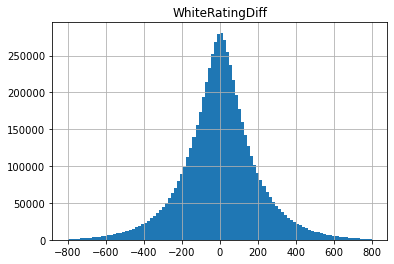

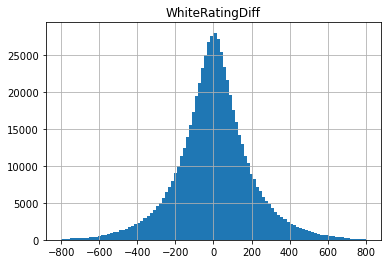

In [11]:
#TESTING DISTRIBUTIONS - RATING DIFFERENTIAL 
#TOP = Distribution of Original DF
completed_chess_games.hist(column = 'WhiteRatingDiff', bins = 100, range = (-800, 800))

#Bottom = Distribution of Cut DF
chess_games_cut.hist(column = 'WhiteRatingDiff', bins = 100, range = (-800, 800))

#Distributions look the same so good cut based on Rating Differential

array([[<AxesSubplot:title={'center':'WhiteElo'}>,
        <AxesSubplot:title={'center':'BlackElo'}>]], dtype=object)

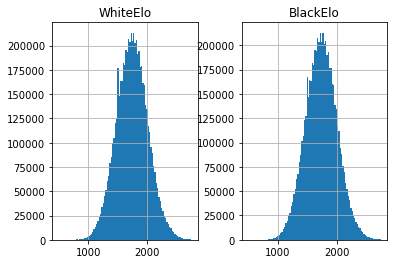

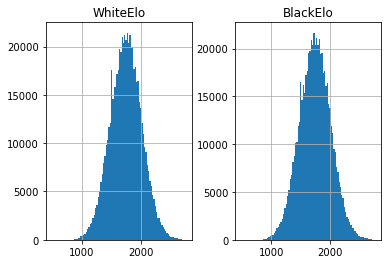

In [12]:
#TESTING DISTRIBUTIONS - RATING  
#TOP = Distribution of Original DF
completed_chess_games.hist(column = ['WhiteElo', 'BlackElo'], bins = 100, range = (500,2750))

#BOTTOM = Distribution of Cut DF
chess_games_cut.hist(column = ['WhiteElo', 'BlackElo'], bins = 100, range = (500,2750))


#Distributions look the same so good cut based on Rating

In [13]:
#TESTING DISTRIBUTIONS - TIME CONTROL
#Time Control distribution - pre slice
#Group by Time Control, and count each occurance of the Control
timecontrol_dist = completed_chess_games.groupby(by = 'TimeControl')
timecontrol_dist = timecontrol_dist.count().sort_values(by = 'Event', ascending=False)


#Calculate the percent of total occurances for each opening 
timecontrol_dist_1 = timecontrol_dist.loc[:, ['Event']]
timecontrol_dist_1 = timecontrol_dist_1.rename(columns={"Event":"Count"})
timecontrol_dist_1['Percent_Tot'] = timecontrol_dist_1['Count']/len(completed_chess_games)
timecontrol_dist_1 = timecontrol_dist_1[timecontrol_dist_1['Percent_Tot'] > 0.0001]

#840 rows - no filter for 0.01% of Total
#189 rows - filter for 0.01% of Total


#Opening distribution - post slice
#Group by opening, and count each occurance of the opening
timecontrol_dist_cut = chess_games_cut.groupby(by = 'TimeControl')
timecontrol_dist_cut = timecontrol_dist_cut.count().sort_values(by = 'Event', ascending=False)
timecontrol_dist_cut

#Calculate the percent of total occurances for each opening 
timecontrol_dist_cut_1 = timecontrol_dist_cut.loc[:, ['Event']]
timecontrol_dist_cut_1 = timecontrol_dist_cut_1.rename(columns={"Event":"CUT_Count"})
timecontrol_dist_cut_1['CUT_Percent_Tot'] = timecontrol_dist_cut_1['CUT_Count']/len(chess_games_cut)
timecontrol_dist_cut_1 = timecontrol_dist_cut_1[timecontrol_dist_cut_1['CUT_Percent_Tot'] > 0.0001]
timecontrol_dist_cut_1

#534 rows - no filter for > 0.01% of Total
#182 rows - filter for > 0.01% of Total


#Joining pre-cut and post-cut tables
tc_joined = timecontrol_dist_1.join(timecontrol_dist_cut_1, on = "TimeControl")
tc_joined['Percent_Diff'] = tc_joined['Percent_Tot'] - tc_joined['CUT_Percent_Tot']
tc_joined

,Count,Percent_Tot,CUT_Count,CUT_Percent_Tot,Percent_Diff
TimeControl,,,,,
300+0,1071549,0.172388,106906.0,0.171988,0.000400
180+0,945369,0.152089,94972.0,0.152789,-0.000700
60+0,909552,0.146327,92614.0,0.148995,-0.002669
600+0,576641,0.092769,58983.0,0.094891,-0.002122
30+0,306403,0.049293,23946.0,0.038524,0.010770
...,...,...,...,...,...
660+7,651,0.000105,82.0,0.000132,-0.000027
300+9,651,0.000105,NaN,NaN,NaN
540+10,641,0.000103,NaN,NaN,NaN
